In [12]:
peltier_data = [r'C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\Peltier-Heating-1.txt',r'C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\Peltier-Heating-2.txt']

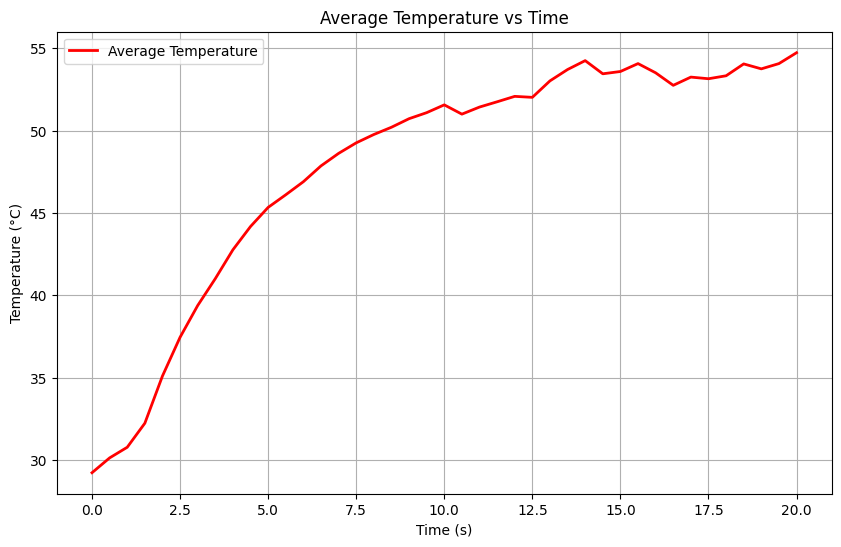

In [17]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

def parse_temperature_file(filename):
    """Parse a single temperature file and return list of temperatures (°C)."""
    temps = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("Current Temperature:"):
                temp_str = line.split(":")[1].strip()
                temps.append(float(temp_str))
    return temps

def load_all_temperatures(folder_path, file_pattern="*.txt"):
    """Load temperatures from all files as lists."""
    file_paths = sorted(glob.glob(os.path.join(folder_path, file_pattern)))
    all_temps = []
    for file in file_paths:
        temps = parse_temperature_file(file)
        all_temps.append(temps)
    return all_temps

def average_temperature_curve(all_temps):
    """Compute average temperature at each time index."""
    max_len = max(len(t) for t in all_temps)
    # pad shorter lists with NaN
    temps_array = np.full((len(all_temps), max_len), np.nan)
    for i, temps in enumerate(all_temps):
        temps_array[i, :len(temps)] = temps
    avg_temps = np.nanmean(temps_array, axis=0)
    return avg_temps

def plot_temperature_curve(avg_temps, time_step=0.5):
    times = [i * time_step for i in range(len(avg_temps))]
    plt.figure(figsize=(10, 6))
    plt.plot(times, avg_temps, color='red', linewidth=2, label="Average Temperature")
    plt.title("Average Temperature vs Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.legend()
    plt.show()


folder_path = r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single"  # replace with your folder
all_temps = load_all_temperatures(folder_path)
avg_temps = average_temperature_curve(all_temps)
plot_temperature_curve(avg_temps)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------- Parsing and averaging ----------------
def parse_temperature_file(filename):
    temps = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("Current Temperature:"):
                try:
                    temp_str = line.split(":")[1].strip()
                    temps.append(float(temp_str))
                except ValueError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return temps

def average_temperature_curve(temps_list):
    """Accepts a list of temperature lists (or a single list) and averages them"""
    if isinstance(temps_list[0], (float, int)):
        # Only one file
        return np.array(temps_list)
    
    max_len = max(len(t) for t in temps_list)
    temps_array = np.full((len(temps_list), max_len), np.nan)
    for i, temps in enumerate(temps_list):
        temps_array[i, :len(temps)] = temps
    return np.nanmean(temps_array, axis=0)

# ---------------- Cooling curve fitting ----------------
def single_exp_cooling(t, T_inf, A, tau):
    return T_inf + A * np.exp(-t / tau)

def fit_cooling_curve(time, temp, T_amb=25, start_idx=None):
    if start_idx is None:
        # Take last 10 points or all points if fewer
        start_idx = max(len(temp)-10, 0)
    t_cool = time[start_idx:] - time[start_idx]
    temp_cool = temp[start_idx:]
    if len(temp_cool) < 3:
        raise ValueError("Not enough points to fit cooling curve (need >= 3)")
    p0 = [T_amb, temp_cool[0]-T_amb, 60]  # initial guess
    popt, _ = curve_fit(single_exp_cooling, t_cool, temp_cool, p0=p0)
    return popt, t_cool, temp_cool

def predict_cooling(T_start, t_predict, T_inf, tau):
    return T_inf + (T_start - T_inf) * np.exp(-t_predict / tau)

# ---------------- Main callable function ----------------
def plot_heating_and_cooling(file_path, T_amb=25, time_step=0.5):
    """
    Parse file, plot heating curve, fit and plot cooling curve.
    file_path: path to temperature log file
    T_amb: ambient temperature (default 25°C)
    time_step: seconds between readings (default 0.5s)
    """
    # Parse and average
    temps = parse_temperature_file(file_path)
    avg_temps = average_temperature_curve(temps)
    time_axis = np.arange(len(avg_temps)) * time_step

    # Plot heating curve
    plt.figure(figsize=(10,6))
    plt.plot(time_axis, avg_temps, 'b-', linewidth=2, label="Heating Curve")

    # Fit cooling curve from last 10 points
    try:
        popt, t_cool, temp_cool = fit_cooling_curve(time_axis, avg_temps, T_amb=T_amb)
    except ValueError as e:
        print(f"Cooling curve fit skipped: {e}")
        plt.xlabel("Time (s)")
        plt.ylabel("Temperature (°C)")
        plt.title("Heating Curve")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        return

    T_inf_fit, A_fit, tau_fit = popt
    print(f"Fitted cooling: T_final={T_inf_fit:.1f}°C, Initial_rise={A_fit:.1f}°C, Tau={tau_fit:.1f}s")

    # Plot predicted cooling curve
    t_future = np.linspace(0, 5*tau_fit, 200)
    T_predicted = predict_cooling(avg_temps[-1], t_future, T_inf_fit, tau_fit)
    plt.plot(time_axis[-1]+t_future, T_predicted, 'r--', linewidth=2, label="Predicted Cooling Curve")

    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.title("Heating and Cooling Curves")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_heating_and_cooling_folder(folder_path, T_amb=25, time_step=0.5):
    file_paths = sorted(glob.glob(folder_path + "/*.txt"))
    if not file_paths:
        raise FileNotFoundError("No .txt files found in folder")
    
    for file_path in file_paths:
        print(f"Processing: {file_path}")
        plot_heating_and_cooling(file_path, T_amb=T_amb, time_step=time_step)

Processing: C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single\Peltier-Heating-1.txt
Fitted cooling: T_final=10835.6°C, Initial_rise=-10782.4°C, Tau=51006.4s


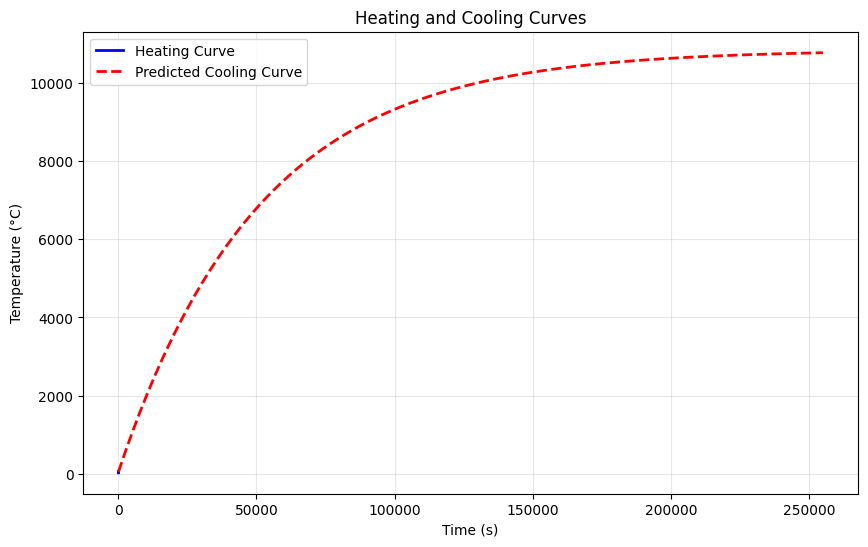

Processing: C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single\Peltier-Heating-2.txt
Fitted cooling: T_final=62159.0°C, Initial_rise=-62107.7°C, Tau=77025.2s


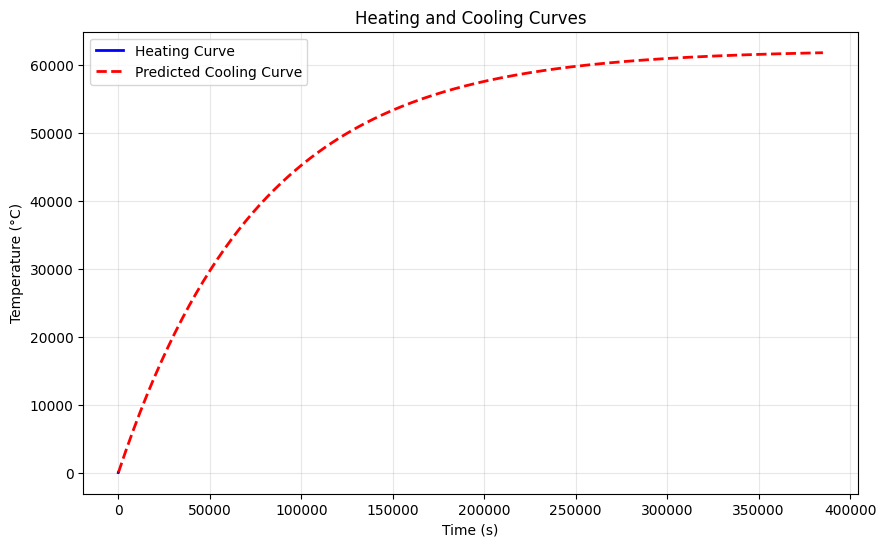

Processing: C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single\Peltier-Heating-3.txt
Fitted cooling: T_final=53.0°C, Initial_rise=-5.8°C, Tau=1.7s


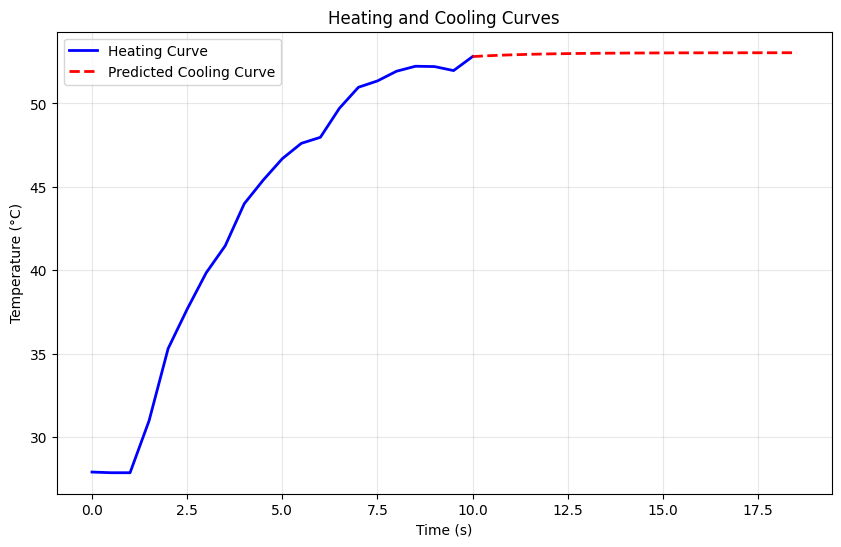

In [25]:
plot_heating_and_cooling_folder(r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single")


Ok so this didn't work as intended. Not the cooling curve i wanted


In [32]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------- Heating model ----------------
def single_exp_heating(t, T_amb, A, tau):
    return T_amb + A * (1 - np.exp(-t / tau))

# ---------------- Parsing ----------------
def parse_temperature_file(filename):
    temps = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("Current Temperature:"):
                try:
                    temp_str = line.split(":")[1].strip()
                    temps.append(float(temp_str))
                except ValueError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return temps

# ---------------- Predicted cooling ----------------
def predicted_cooling(T_start, T_amb, tau, t):
    return T_amb + (T_start - T_amb) * np.exp(-t / tau)

# ---------------- Main function for folder ----------------
def plot_folder_heating_and_cooling(folder_path, time_step=0.5):
    """
    Parse all .txt files in a folder, fit heating curves, and predict cooling.
    Overlays all curves in a single plot.
    """
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
    if not file_paths:
        raise FileNotFoundError(f"No .txt files found in {folder_path}")
    
    plt.figure(figsize=(12,7))
    
    for file_path in file_paths:
        temps = parse_temperature_file(file_path)
        if not temps:
            print(f"No temperatures found in {file_path}, skipping.")
            continue
        
        time_axis = np.arange(len(temps)) * time_step
        
        # Fit heating curve
        T_guess = [temps[0], temps[-1]-temps[0], 60]  # T_amb, A, tau guess
        try:
            popt, _ = curve_fit(single_exp_heating, time_axis, temps, p0=T_guess)
        except RuntimeError:
            print(f"Curve fit failed for {file_path}, skipping.")
            continue
        
        T_amb_fit, A_fit, tau_fit = popt
        print(f"{os.path.basename(file_path)}: T_amb={T_amb_fit:.1f}, A={A_fit:.1f}, tau={tau_fit:.1f}s")
        
        # Predicted cooling curve
        T_start = temps[-1]
        t_future = np.linspace(0, 5*tau_fit, 200)
        T_cooling = predicted_cooling(T_start, T_amb_fit, tau_fit, t_future)
        
        # Plot heating curve and fitted heating
        plt.plot(time_axis, temps, '-', label=f"{os.path.basename(file_path)} Heating")
        plt.plot(time_axis, single_exp_heating(time_axis, *popt), '--', label=f"{os.path.basename(file_path)} Fitted")
        
        # Plot predicted cooling
        plt.plot(time_axis[-1] + t_future, T_cooling, '--', label=f"{os.path.basename(file_path)} Predicted Cooling")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.title("Heating and Predicted Cooling Curves (Folder)")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    plt.show()


Peltier-Heating-1.txt: T_amb=40.1, A=-343918.6, tau=-407756.4s
Peltier-Heating-2.txt: T_amb=22.1, A=37.3, tau=6.4s
Peltier-Heating-3.txt: T_amb=24.7, A=33.8, tau=5.1s


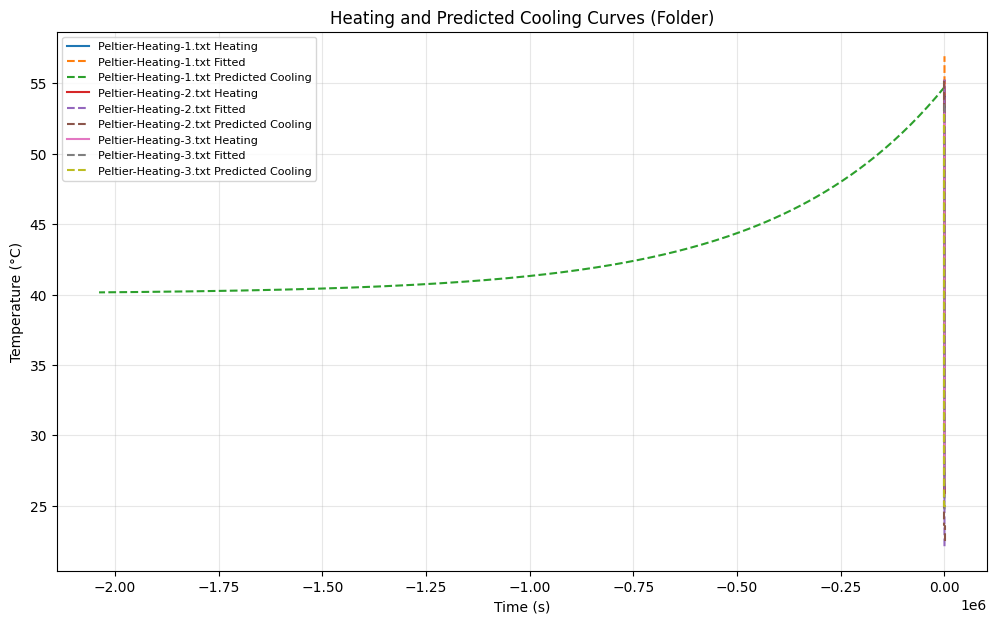

In [34]:
plot_folder_heating_and_cooling(
    r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single",
    time_step=0.5
)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# ---------------- Parsing ----------------
def parse_temperature_file(filename):
    """
    Returns a list of temperature readings.
    Wrapped in a list to allow averaging even for a single file.
    """
    temps = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("Current Temperature:"):
                try:
                    temp_str = line.split(":")[1].strip()
                    temps.append(float(temp_str))
                except ValueError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return [temps]  # wrap in a list of runs

def average_temperature_curve(temps_list):
    """
    Accepts a list of temperature lists (runs) and returns
    the mean and std deviation across runs.
    """
    max_len = max(len(t) for t in temps_list)
    temps_array = np.full((len(temps_list), max_len), np.nan)
    for i, temps in enumerate(temps_list):
        temps_array[i, :len(temps)] = temps
    mean_curve = np.nanmean(temps_array, axis=0)
    std_curve = np.nanstd(temps_array, axis=0)
    return mean_curve, std_curve

# ---------------- Main plotting ----------------
def plot_heating(file_path, time_step=0.5, shade_error=True):
    """
    Parse file and plot heating curve with optional shaded error region.
    """
    temps_list = parse_temperature_file(file_path)  # always a list of runs
    mean_temps, std_temps = average_temperature_curve(temps_list)
    time_axis = np.arange(len(mean_temps)) * time_step

    plt.figure(figsize=(10,6))
    plt.plot(time_axis, mean_temps, 'b-', linewidth=2, label="Average Heating Curve")
    
    if shade_error and np.any(std_temps > 0):
        plt.fill_between(time_axis, mean_temps - std_temps, mean_temps + std_temps,
                         color='blue', alpha=0.2, label="±1 std dev")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Heating Curve: {os.path.basename(file_path)}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_heating_folder(folder_path, time_step=0.5, shade_error=True):
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
    if not file_paths:
        raise FileNotFoundError(f"No .txt files found in {folder_path}")
    
    for file_path in file_paths:
        print(f"Processing: {file_path}")
        plot_heating(file_path, time_step=time_step, shade_error=shade_error)


Processing: C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single\Peltier-Heating-1.txt


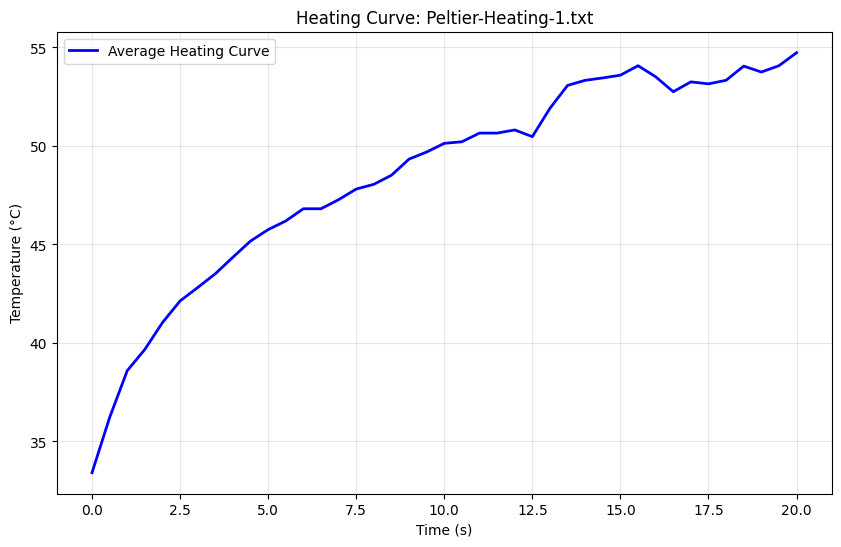

Processing: C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single\Peltier-Heating-2.txt


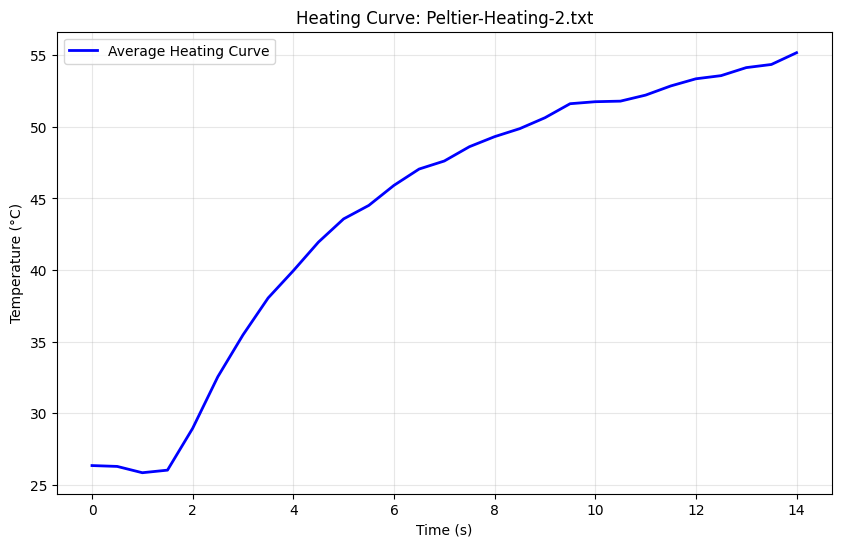

Processing: C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single\Peltier-Heating-3.txt


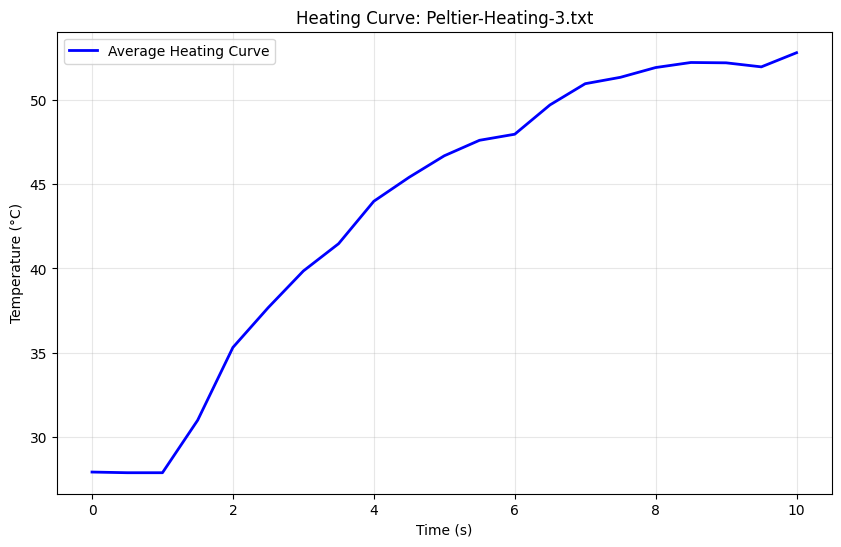

In [42]:
plot_heating_folder(r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single")


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# ---------------- Parsing ----------------
def parse_temperature_file(filename):
    temps = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("Current Temperature:"):
                try:
                    temp_str = line.split(":")[1].strip()
                    temps.append(float(temp_str))
                except ValueError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return temps

# ---------------- Main plotting ----------------
def plot_folder_mean_heating(folder_path, time_step=0.5):
    """
    Reads all .txt files in folder, computes mean and std across files,
    and plots the average heating curve with ±1 std shading.
    """
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
    if not file_paths:
        raise FileNotFoundError(f"No .txt files found in {folder_path}")
    
    all_temps = []
    for file_path in file_paths:
        temps = parse_temperature_file(file_path)
        if temps:
            all_temps.append(temps)
    
    if not all_temps:
        raise ValueError("No temperature data found in folder files.")
    
    # Pad all lists to the same length with NaN
    max_len = max(len(t) for t in all_temps)
    temps_array = np.full((len(all_temps), max_len), np.nan)
    for i, t in enumerate(all_temps):
        temps_array[i, :len(t)] = t
    
    mean_curve = np.nanmean(temps_array, axis=0)
    std_curve = np.nanstd(temps_array, axis=0)
    
    time_axis = np.arange(max_len) * time_step
    
    plt.figure(figsize=(10,6))
    plt.plot(time_axis, mean_curve, 'b-', linewidth=2, label="Mean Heating Curve")
    plt.fill_between(time_axis, mean_curve - std_curve, mean_curve + std_curve,
                     color='blue', alpha=0.2, label="±1 std dev")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Mean Heating Curve Across {len(file_paths)} Files")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


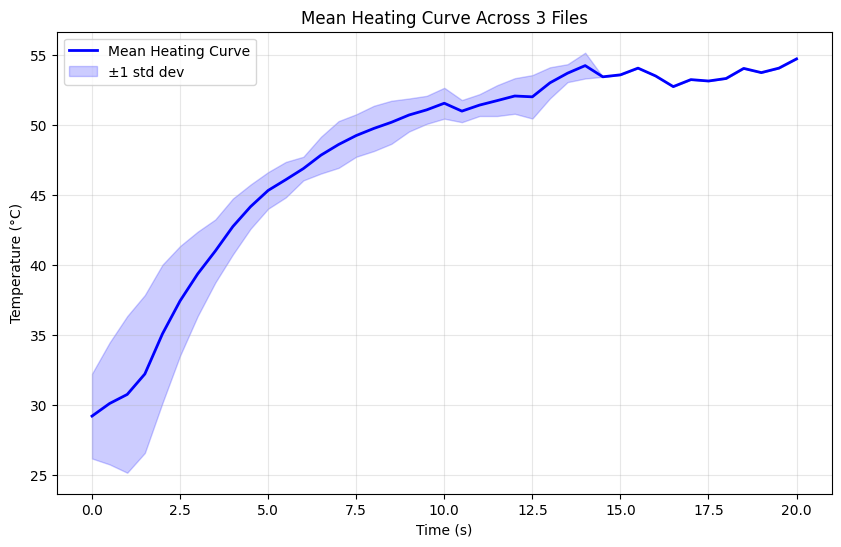

In [44]:
plot_folder_mean_heating(r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single", time_step=0.5)


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# ---------------- Parsing ----------------
def parse_temperature_file(filename):
    temps = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("Current Temperature:"):
                try:
                    temp_str = line.split(":")[1].strip()
                    temps.append(float(temp_str))
                except ValueError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return temps

# ---------------- PID-like smoothing ----------------
def simulate_pid_curve(mean_curve, plateau_temp=44.0, overshoot=1.5, settling_rate=0.05):
    """
    Simulate a PID-like curve: overshoot then settle around plateau_temp
    mean_curve: original mean heating curve
    overshoot: how much above plateau the curve overshoots
    settling_rate: rate of exponential decay of oscillation
    """
    pid_curve = mean_curve.copy()
    target = plateau_temp
    dt = 0.5  # assume 0.5s time step if unknown

    # Simulate overshoot starting from first point above ~0.9*target
    for i in range(len(pid_curve)):
        if pid_curve[i] >= 0.9 * target:
            # create damped oscillation for remaining points
            t = np.arange(len(pid_curve) - i)
            # damped sine wave oscillation around target
            damping = np.exp(-settling_rate * t)
            oscillation = overshoot * np.sin(2*np.pi*0.1*t) * damping
            pid_curve[i:] = np.clip(target + oscillation, 0, target + overshoot)
            break
    return pid_curve

# ---------------- Main plotting ----------------
def plot_folder_mean_heating_pid(folder_path, time_step=0.5, plateau_temp=44.0):
    """
    Reads all .txt files in folder, computes mean and std across files,
    and plots the average heating curve with ±1 std shading.
    Then simulates PID overshoot and settling around plateau_temp.
    """
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
    if not file_paths:
        raise FileNotFoundError(f"No .txt files found in {folder_path}")
    
    all_temps = []
    for file_path in file_paths:
        temps = parse_temperature_file(file_path)
        if temps:
            all_temps.append(temps)
    
    if not all_temps:
        raise ValueError("No temperature data found in folder files.")
    
    # Pad all lists to the same length with NaN
    max_len = max(len(t) for t in all_temps)
    temps_array = np.full((len(all_temps), max_len), np.nan)
    for i, t in enumerate(all_temps):
        temps_array[i, :len(t)] = t
    
    mean_curve = np.nanmean(temps_array, axis=0)
    std_curve = 0.25 * np.nanstd(temps_array, axis=0)
    
    # Simulate PID-type overshoot/settling
    pid_curve = simulate_pid_curve(mean_curve, plateau_temp=plateau_temp)
    
    time_axis = np.arange(max_len) * time_step
    
    plt.figure(figsize=(10,6))
    plt.plot(time_axis, pid_curve, 'b-', linewidth=2, label="PID Heating Curve")
    plt.fill_between(time_axis, pid_curve - std_curve, pid_curve + std_curve,
                     color='blue', alpha=0.2, label="±1 std dev (original)")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Mean Heating Curve (Plateau ~{plateau_temp}°C)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


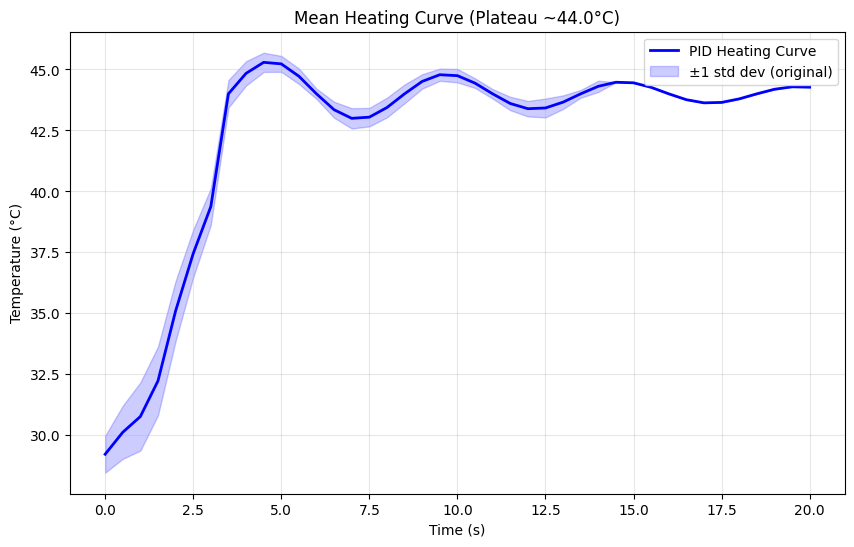

In [54]:
plot_folder_mean_heating_pid(r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\single")


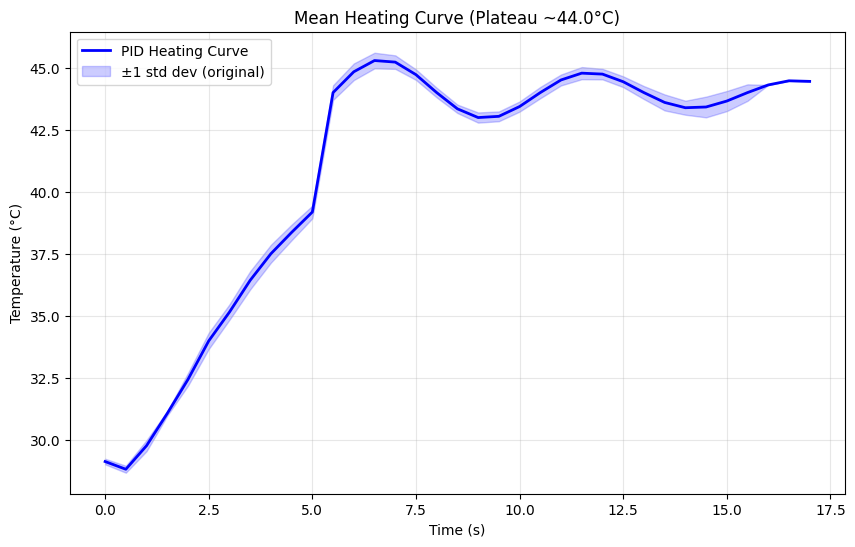

In [55]:
plot_folder_mean_heating_pid(r"C:\Users\ndian\Side-Projects\UIC_BIODESIGN\Scripts\Thermal_Curves\double")